In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'felipekespinoza'
os.environ['KAGGLE_KEY'] = '7e80d05011f31755cc452cf4732ea604'

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = 'parisrohan/credit-score-classification'
api.dataset_download_files(dataset, path='.', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/parisrohan/credit-score-classification


2024-08-07 16:57:33,663 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001FE512430E0>: Failed to resolve 'www.kaggle.com' ([Errno 11001] getaddrinfo failed)")': /api/v1/datasets/download/parisrohan/credit-score-classification?datasetVersionNumber=None
2024-08-07 16:57:33,978 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001FE310FC770>: Failed to resolve 'www.kaggle.com' ([Errno 11001] getaddrinfo failed)")': /api/v1/datasets/download/parisrohan/credit-score-classification?datasetVersionNumber=None


In [4]:
import pandas as pd 

data_train = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\train.csv')
data_test = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\test.csv')

C:\Users\wipip\AppData\Local\Temp\ipykernel_6284\2209697490.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\train.csv')


Guardamos los conjuntos de datos en nuestro directorio de datos no procesados

In [ ]:
#data_test.to_csv(r'')

In [5]:
print(data_test.info() , data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [6]:
import sqlite3 

In [7]:
conn = sqlite3.connect('database_credito.db')

In [8]:
cursor = conn.cursor()

In [9]:
#data_train.to_sql('training_set', conn, if_exists='replace', index=False)
#data_test.to_sql('testing_set', conn, if_exists='replace', index=False)

In [10]:
#conn.commit()

In [11]:
query_1 = ''' 
SELECT name FROM sqlite_master WHERE type='table';

'''
cursor.execute(query_1)
tables = cursor.fetchall()

In [12]:
print("Tablas en la base de datos:")
for table in tables:
    print(table[0])

Tablas en la base de datos:
training_set
testing_set


In [13]:
#tabla_prueba = pd.read_sql_query('SELECT * FROM training_set', conn)
#tabla_prueba.head()

In [14]:
query_2 = ''' 
SELECT ID, COUNT(*)
FROM training_set
GROUP BY ID
HAVING COUNT(*) > 1;
'''
duplicados_en_training_set = pd.read_sql_query(query_2, conn )

In [15]:
print(duplicados_en_training_set.shape)

(0, 2)


Con este query podemos comprobar que no existen filas duplicadas dentro de nuestro data set de training

In [16]:
data_1 = pd.read_sql_query('SELECT * FROM training_set', conn)

In [17]:
for tabla in tables:
    print(f"\nEstructura de la tabla {tabla[0]}:")
    cursor.execute(f"PRAGMA table_info({tabla[0]});")
    columnas = cursor.fetchall()
    for columna in columnas:
        print(f"{columna[1]} - {columna[2]}")


Estructura de la tabla training_set:
ID - TEXT
Customer_ID - TEXT
Month - TEXT
Name - TEXT
Age - TEXT
SSN - TEXT
Occupation - TEXT
Annual_Income - TEXT
Monthly_Inhand_Salary - REAL
Num_Bank_Accounts - INTEGER
Num_Credit_Card - INTEGER
Interest_Rate - INTEGER
Num_of_Loan - TEXT
Type_of_Loan - TEXT
Delay_from_due_date - INTEGER
Num_of_Delayed_Payment - TEXT
Changed_Credit_Limit - TEXT
Num_Credit_Inquiries - REAL
Credit_Mix - TEXT
Outstanding_Debt - TEXT
Credit_Utilization_Ratio - REAL
Credit_History_Age - TEXT
Payment_of_Min_Amount - TEXT
Total_EMI_per_month - REAL
Amount_invested_monthly - TEXT
Payment_Behaviour - TEXT
Monthly_Balance - TEXT
Credit_Score - TEXT

Estructura de la tabla testing_set:
ID - TEXT
Customer_ID - TEXT
Month - TEXT
Name - TEXT
Age - TEXT
SSN - TEXT
Occupation - TEXT
Annual_Income - TEXT
Monthly_Inhand_Salary - REAL
Num_Bank_Accounts - INTEGER
Num_Credit_Card - INTEGER
Interest_Rate - INTEGER
Num_of_Loan - TEXT
Type_of_Loan - TEXT
Delay_from_due_date - INTEGER
Nu

In [18]:
conn.commit()

Por el momento cerramos el uso de la base de datos, una vez que analizamos la estructura de las dos tablas podemos tener una mejor idea de el tipo de datos con el que estamos trabajando, con ello podemos proceder a realizar un analisis descriptivo.

Vamos a empezar a describir el training set al cual llamamos como data_1 una vez que lo llamamos desde nuestra base de datos.

In [19]:
data_1.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Vamos a realizar un cambio de nombre en nuestras variables para que el analisi sea mas comprensible y facil de entender

In [27]:
data_1.rename(columns={
    'ID': 'ID',
    'Customer_ID': 'ID_Cliente',
    'Month': 'Mes',
    'Name': 'Nombre',
    'Age': 'Edad',
    'SSN': 'Numero_Seguridad_Social',
    'Occupation': 'Ocupacion',
    'Annual_Income': 'Ingreso_Anual',
    'Monthly_Inhand_Salary': 'Salario_Mensual_En_Mano',
    'Num_Bank_Accounts': 'Numero_Cuentas_Bancarias',
    'Num_Credit_Card': 'Numero_Tarjetas_Credito',
    'Interest_Rate': 'Tasa_Interes',
    'Num_of_Loan': 'Numero_Prestamos',
    'Type_of_Loan': 'Tipo_Prestamos',
    'Delay_from_due_date': 'Retraso_Promedio_Pagos',
    'Num_of_Delayed_Payment': 'Numero_Promedio_Pagos_Retrasados',
    'Changed_Credit_Limit': 'Cambio_Limite_Credito',
    'Num_Credit_Inquiries': 'Numero_Consultas_Credito',
    'Credit_Mix': 'Mezcla_Credito',
    'Outstanding_Debt': 'Deuda_Pendiente',
    'Credit_Utilization_Ratio': 'Ratio_Uso_Credito',
    'Credit_History_Age': 'Antiguedad_Historial_Credito',
    'Payment_of_Min_Amount': 'Pago_Monto_Minimo',
    'Total_EMI_per_month': 'Pagos_Mensuales_EMI',
    'Amount_invested_monthly': 'Monto_Mensual_Invertido',
    'Payment_Behaviour': 'Comportamiento_Pago',
    'Monthly_Balance': 'Balance_Mensual',
    'Credit_Score': 'Puntaje_Credito'
}, inplace=True)

data_1.head()


,ID,ID_Cliente,Mes,Nombre,Edad,Numero_Seguridad_Social,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,...,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual,Puntaje_Credito
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,None,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [24]:
data_test.rename(columns={
    'ID': 'ID',
    'Customer_ID': 'ID_Cliente',
    'Month': 'Mes',
    'Name': 'Nombre',
    'Age': 'Edad',
    'SSN': 'Numero_Seguridad_Social',
    'Occupation': 'Ocupacion',
    'Annual_Income': 'Ingreso_Anual',
    'Monthly_Inhand_Salary': 'Salario_Mensual_En_Mano',
    'Num_Bank_Accounts': 'Numero_Cuentas_Bancarias',
    'Num_Credit_Card': 'Numero_Tarjetas_Credito',
    'Interest_Rate': 'Tasa_Interes',
    'Num_of_Loan': 'Numero_Prestamos',
    'Type_of_Loan': 'Tipo_Prestamos',
    'Delay_from_due_date': 'Retraso_Promedio_Pagos',
    'Num_of_Delayed_Payment': 'Numero_Promedio_Pagos_Retrasados',
    'Changed_Credit_Limit': 'Cambio_Limite_Credito',
    'Num_Credit_Inquiries': 'Numero_Consultas_Credito',
    'Credit_Mix': 'Mezcla_Credito',
    'Outstanding_Debt': 'Deuda_Pendiente',
    'Credit_Utilization_Ratio': 'Ratio_Uso_Credito',
    'Credit_History_Age': 'Antiguedad_Historial_Credito',
    'Payment_of_Min_Amount': 'Pago_Monto_Minimo',
    'Total_EMI_per_month': 'Pagos_Mensuales_EMI',
    'Amount_invested_monthly': 'Monto_Mensual_Invertido',
    'Payment_Behaviour': 'Comportamiento_Pago',
    'Monthly_Balance': 'Balance_Mensual'
}, inplace=True)

data_test.head()


,ID,ID_Cliente,Mes,Nombre,Edad,Numero_Seguridad_Social,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,...,Numero_Consultas_Credito,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


Una vez que hacemos esto podemos empezar a descartar variables que son redundantemente poco utiles para nuestras predicciones 

In [34]:
#haremos un chequeo de duplicados con id, costumer id y nombre de forma rapida

duplicated_rows = data_1.duplicated(subset=['ID', 'ID_Cliente', 'Nombre'])
print("Filas duplicadas basadas en 'ID', 'ID_Cliente', 'Nombre':")
print(data_1[duplicated_rows])



Filas duplicadas basadas en 'ID', 'ID_Cliente', 'Nombre':
Empty DataFrame
Columns: [ID, ID_Cliente, Mes, Nombre, Edad, Numero_Seguridad_Social, Ocupacion, Ingreso_Anual, Salario_Mensual_En_Mano, Numero_Cuentas_Bancarias, Numero_Tarjetas_Credito, Tasa_Interes, Numero_Prestamos, Tipo_Prestamos, Retraso_Promedio_Pagos, Numero_Promedio_Pagos_Retrasados, Cambio_Limite_Credito, Numero_Consultas_Credito, Mezcla_Credito, Deuda_Pendiente, Ratio_Uso_Credito, Antiguedad_Historial_Credito, Pago_Monto_Minimo, Pagos_Mensuales_EMI, Monto_Mensual_Invertido, Comportamiento_Pago, Balance_Mensual, Puntaje_Credito]
Index: []

[0 rows x 28 columns]


Confirmamos no tener filas duplicadas

In [30]:
data_1.columns  


Index(['ID', 'ID_Cliente', 'Mes', 'Nombre', 'Edad', 'Numero_Seguridad_Social',
       'Ocupacion', 'Ingreso_Anual', 'Salario_Mensual_En_Mano',
       'Numero_Cuentas_Bancarias', 'Numero_Tarjetas_Credito', 'Tasa_Interes',
       'Numero_Prestamos', 'Tipo_Prestamos', 'Retraso_Promedio_Pagos',
       'Numero_Promedio_Pagos_Retrasados', 'Cambio_Limite_Credito',
       'Numero_Consultas_Credito', 'Mezcla_Credito', 'Deuda_Pendiente',
       'Ratio_Uso_Credito', 'Antiguedad_Historial_Credito',
       'Pago_Monto_Minimo', 'Pagos_Mensuales_EMI', 'Monto_Mensual_Invertido',
       'Comportamiento_Pago', 'Balance_Mensual', 'Puntaje_Credito'],
      dtype='object')

En este caso podemos ver en la lista variables como id, id de cliente, mes, nombre y numero de seguro social, que son variables de identificacion que no tienen valor para el modelo que vamos a crear, por lo que las vamos a descartar para agilizar el proceso de analisis.

In [35]:
data_2 = data_1[[
    #'ID', 
    #'ID_Cliente', 
    #'Mes', 
    #'Nombre', 
    'Edad', 
    #'Numero_Seguridad_Social',
    'Ocupacion',
    'Ingreso_Anual', 
    'Salario_Mensual_En_Mano',
    'Numero_Cuentas_Bancarias', 
    'Numero_Tarjetas_Credito',
    'Tasa_Interes',
    'Numero_Prestamos',
    'Tipo_Prestamos',
    'Retraso_Promedio_Pagos',
    'Numero_Promedio_Pagos_Retrasados',
    'Cambio_Limite_Credito',
    'Numero_Consultas_Credito',
    'Mezcla_Credito',
    'Deuda_Pendiente',
    'Ratio_Uso_Credito',
    'Antiguedad_Historial_Credito',
    'Pago_Monto_Minimo', 
    'Pagos_Mensuales_EMI', 
    'Monto_Mensual_Invertido',
    'Comportamiento_Pago',
    'Balance_Mensual',
    'Puntaje_Credito']].copy()

In [36]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Edad                              100000 non-null  object 
 1   Ocupacion                         100000 non-null  object 
 2   Ingreso_Anual                     100000 non-null  object 
 3   Salario_Mensual_En_Mano           84998 non-null   float64
 4   Numero_Cuentas_Bancarias          100000 non-null  int64  
 5   Numero_Tarjetas_Credito           100000 non-null  int64  
 6   Tasa_Interes                      100000 non-null  int64  
 7   Numero_Prestamos                  100000 non-null  object 
 8   Tipo_Prestamos                    88592 non-null   object 
 9   Retraso_Promedio_Pagos            100000 non-null  int64  
 10  Numero_Promedio_Pagos_Retrasados  92998 non-null   object 
 11  Cambio_Limite_Credito             100000 non-null  ob

Para iniciar con el analisis descriptivo podemos identificar valores faltantes o nulos dentro de 9 columnas en el data set, se deberan imputar o eliminar mas adelante dependiendo de lo que sea mejor para el analisis, aniadiendo a esto tambien tendremos que tomar en cuenta si tenemos datos atipicos que debamos imputar.

El data set incialmente tiene 27 caracteristicas y 100,000 instancias.

Tenemos una gran cantidad de caracteristicas que son identificadas como objetos por pandas, por lo que mas adelante haremos una analisis a detalle sobre si debemos darle un formato especifico al tipo de dato  para poder trabajar con el a medida que avance el analisis.

In [37]:
data_2.describe()

,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Retraso_Promedio_Pagos,Numero_Consultas_Credito,Ratio_Uso_Credito,Pagos_Mensuales_EMI
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


Vamos a iniciar describiendo nuestras variables numericas

Salario mensual a la mano: (contiene valores nulos: aprox 16 mil)

Es una variable que parece indicar el salario que se tiene como dinero liquido de forma mensual. Podemos ver una media salarial de 4,194 dolares (asumimos la moneda debido a que el data set es de estados unidos), tenemos una variacion estandar de 3,183 por lo que es importante denotar que hay una dispersion relativamente significante. tenemos un primer cuartil de 1,625 por lo que sabeos que el 25% de los salarios son mas bajos que este numero. La mediana es de 3,093, esto significa que el 50% de las personas tienen un salario menor a este numero. el tercer cuartil nos dice que el 75% de las personas estaran con un salario mensual disponible menor a 5,975. Finalmente tendremos un minimo de salario de 303 dolares y un maximo de 15,204. Con un minimo diferente a cero sabremos que en esta columna no es necesario imputar valores de cero.

#### Es importante diferenciar las deducciones de la deuda, ya que las deducciones se refieren a impuestos principalmente, sabemos que esta es la cantidad de dinero que la persona recibe en su cuenta mensualmente, es una de las principales caracteristicas ya que a mayor salario es mayor la capacidad de pagar las deudas y viceversa.

numero de cuentas de banco que posee el cliente: (sin valores nulos)

media de 17, variacion estandar de 17, primer cuartil de 3, mediana de 6 y tercer cuartil de 7, con un maximo de 1798 y un minimo de menos uno.( * * * * Investigar el numero de cuentas comun en USA) 

#### Los maximos y minimos nos indican que tenemos datos atipicos ya que no tiene sentido tener menos 1 de numero de cuentas o de 1798 por lo que se debe limpiar esto.

Cantidad de tarjetas de credito que tiene una persona: (0 valores nulos):
Estadisticamente tendremos una media de 22, una desviacion estandar de 129, tendremos un minimo de 0, maximo de 1499, 25% por debajo de 4, 50% por debajo de 5 y 75% por debajo de 7.
#### El maximo indica outilers, a la vez se debe tener cuidado para identificar el numero de tarjertas de credito que pondremos como limite normal debido a que un numero alto puede ser un indicador de riesgo para el score crediticio. 


Tasa de interes de las tarjetas de credito: (sin valores nulos)

Tenemos un rango de 1 a 5797% (indicacion de outliers).
media de 72.5% y desviacion de 466%.
25% por debajo de 8%, mediana de 13% y 75% por debajo de 20%.
#### Con nuestros cuantiles podemos estar seguros de que es necesario hacer un analisis de outlier y tratar estos datos para determinar las tasas de interes validas, debido a que es comun que las tasas de interes esten normalizadas en el mercado, tambien deben ser verificadas por instituciones financieras, por lo que es muy posible que los valores por encima cierto rango sean errores.

Dias de retraso desde la fecha de vencimiento de pago:
Rango de -5 a 67 dias (el minimo indica valores que debemos revisar)
media de 21.1 dias
desviacion estandar de 14.9 dias
vemos una mediana de 18, 25% por debajo de 10 y 75% por debajo de 28.
#### Los valores negativos en este caso podrian indicar que se tiene un pago anticipado, sin embargo esto puede ser problematico para el modelo ya que el retraso en el pago es caracteristico de la generacion de intereses extra lo cual a su vez es un indicador de una conducta financiera riesgosa cosa que es importante para determinar un score crediticio por lo que se evaluara si es necesario normalizar los datos negativos a cero para mantener la estructura para el modelo.


Numero de consultas de credito:
media de 27.8, desviacion estandar de 193.
cuantiles de 25% por debajo de 3, 50% por debajo de 6, 75% por debajo de 9, minetras que el rango es de 0 a 2597.
#### Un numero alto de consultas se asocia con un comportamiento riesgoso, por lo que se deben limpiar los outliers, a la vez tenemos que averiguar si es posible consultar o crear un indicador de que tan recientes son las consultas ya que un numero alto de consultas recientes es aun mayor indicador de riesgo.

Radio de utilizacion de credito: (sin valores nulos):
Media del 32.3%
std 5.12%
cuantiles: 25%: 28.1, 50%: 32.3, 75%: 36.5 
minimo de 20% y maximo de 50%. 
#### El radio de utilizacion de credito nos dice el porcentaje de credito se esta utilizando acorde al total de credito que se tiene disponible, es buena practica que este radio sea menor al 30% por lo que entre mas alto es el numero es un mayor indicador de riesgo para la institucion. Mantener un radio menor sera indicador de un mejor score crediticio. 

Cuota mensual equivalente: (sin valores nulos) 
Es la cantidad total de dinero que una persona paga por prestamos o creditos mensualmente, suma de hipoteca, carro, pp, etc. 
#### esto se debe comparar con el ingreso mensual para determinar que cantidad de ese ingreso se va a pagos mensuales.
media de 1,403, std de 8,306
25% bajo 30, 50% bajo 69, 75% bajo 161
rango de 0 a 82,331 (el maximo puede ser un outlier pero esto no es del todo correcto ya que puede representar un caso verdadero y coherente de deuda)

#### Un EMI alto es un indicador de sobrecarga financiera por lo que sera importante para nuestro modelo. Se debe tomar en cuenta que comparado con el salario de ingreso tendremos la capacidad de una persona de pagar sus deudas actuales.
### Crearemos una columna que combine salario con deuda mensuales para determinar un porcentaje del salario disponible que se va a el pago de la deuda, si tenemos un radio alto de deuda / ingreso sera un indicador de alto riesgo de incumplimiento ya que demuestra una incapacidad de pagar nuevos creditos.











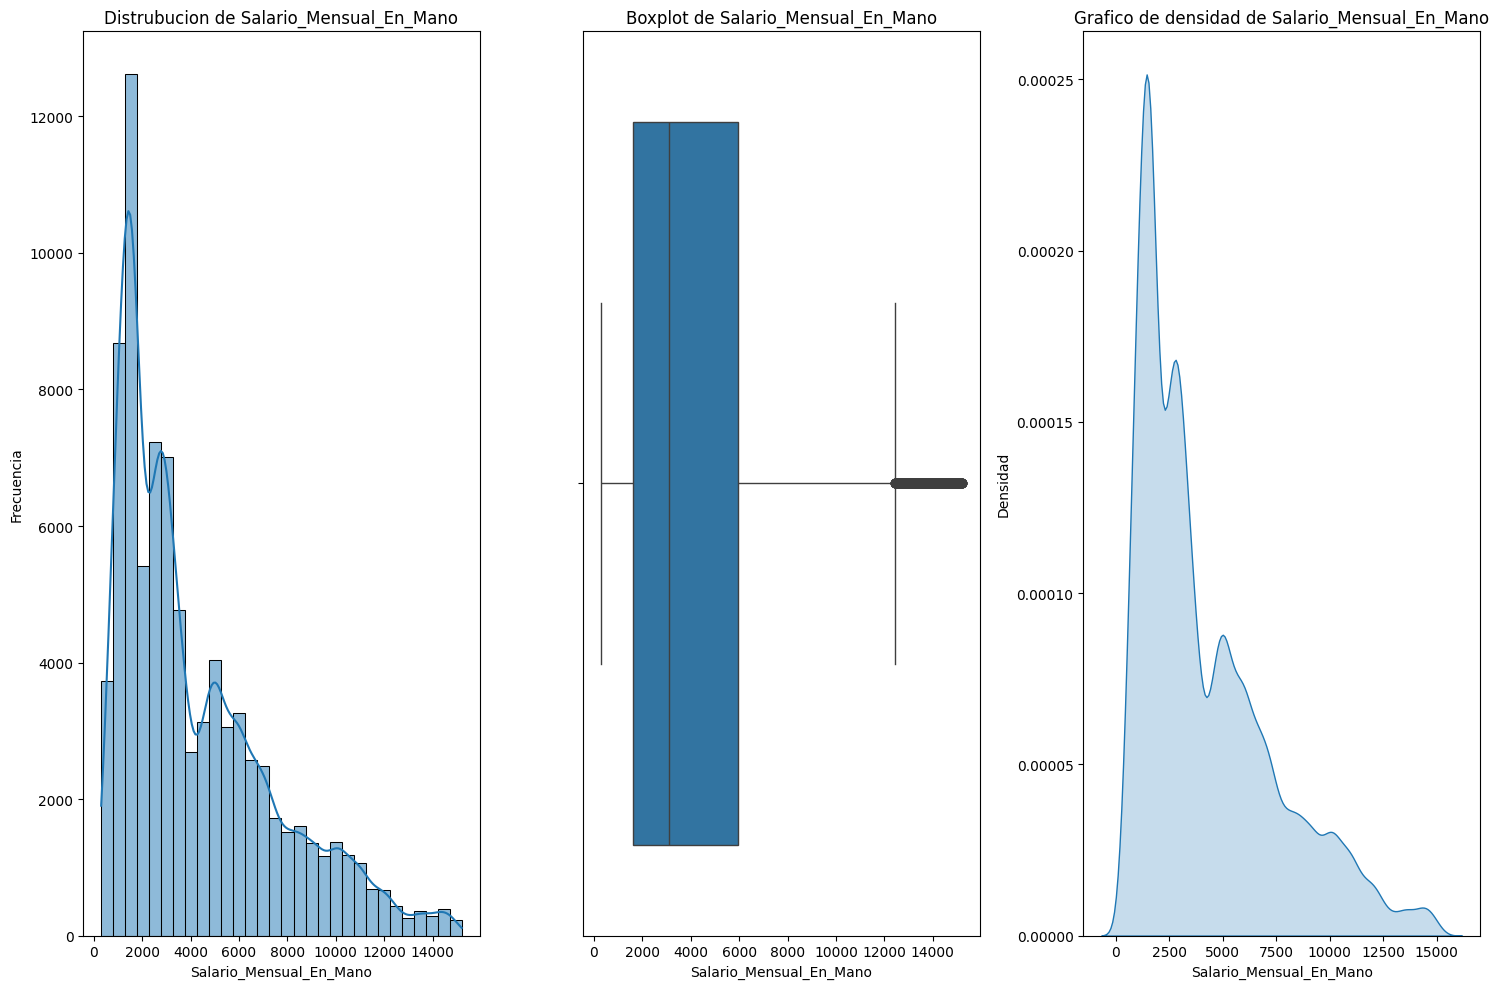

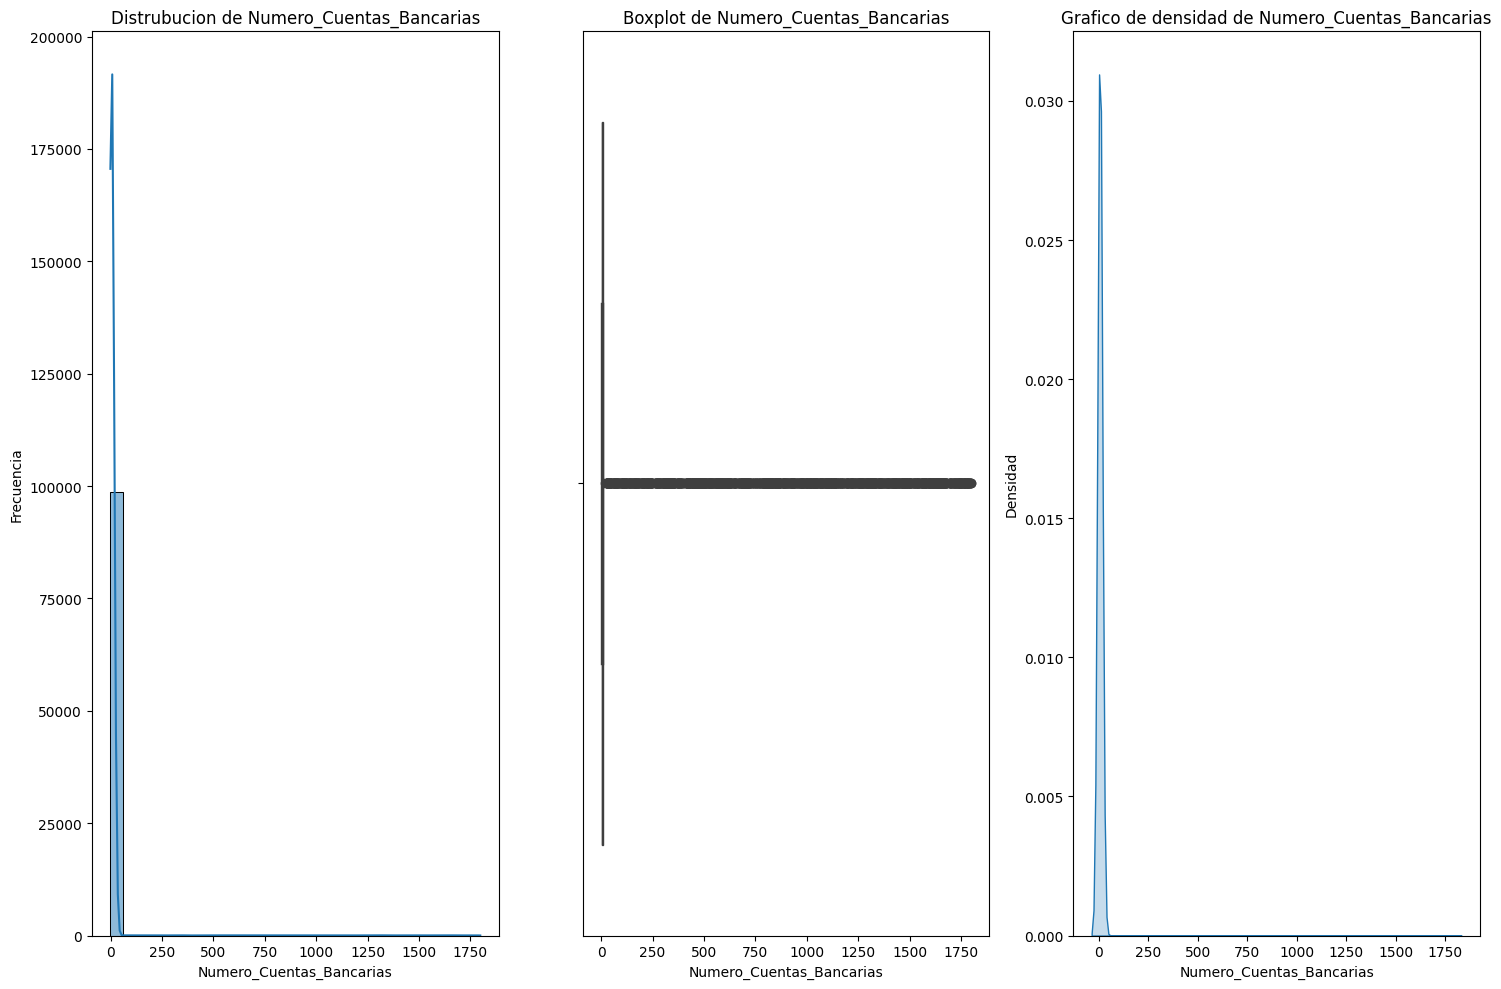

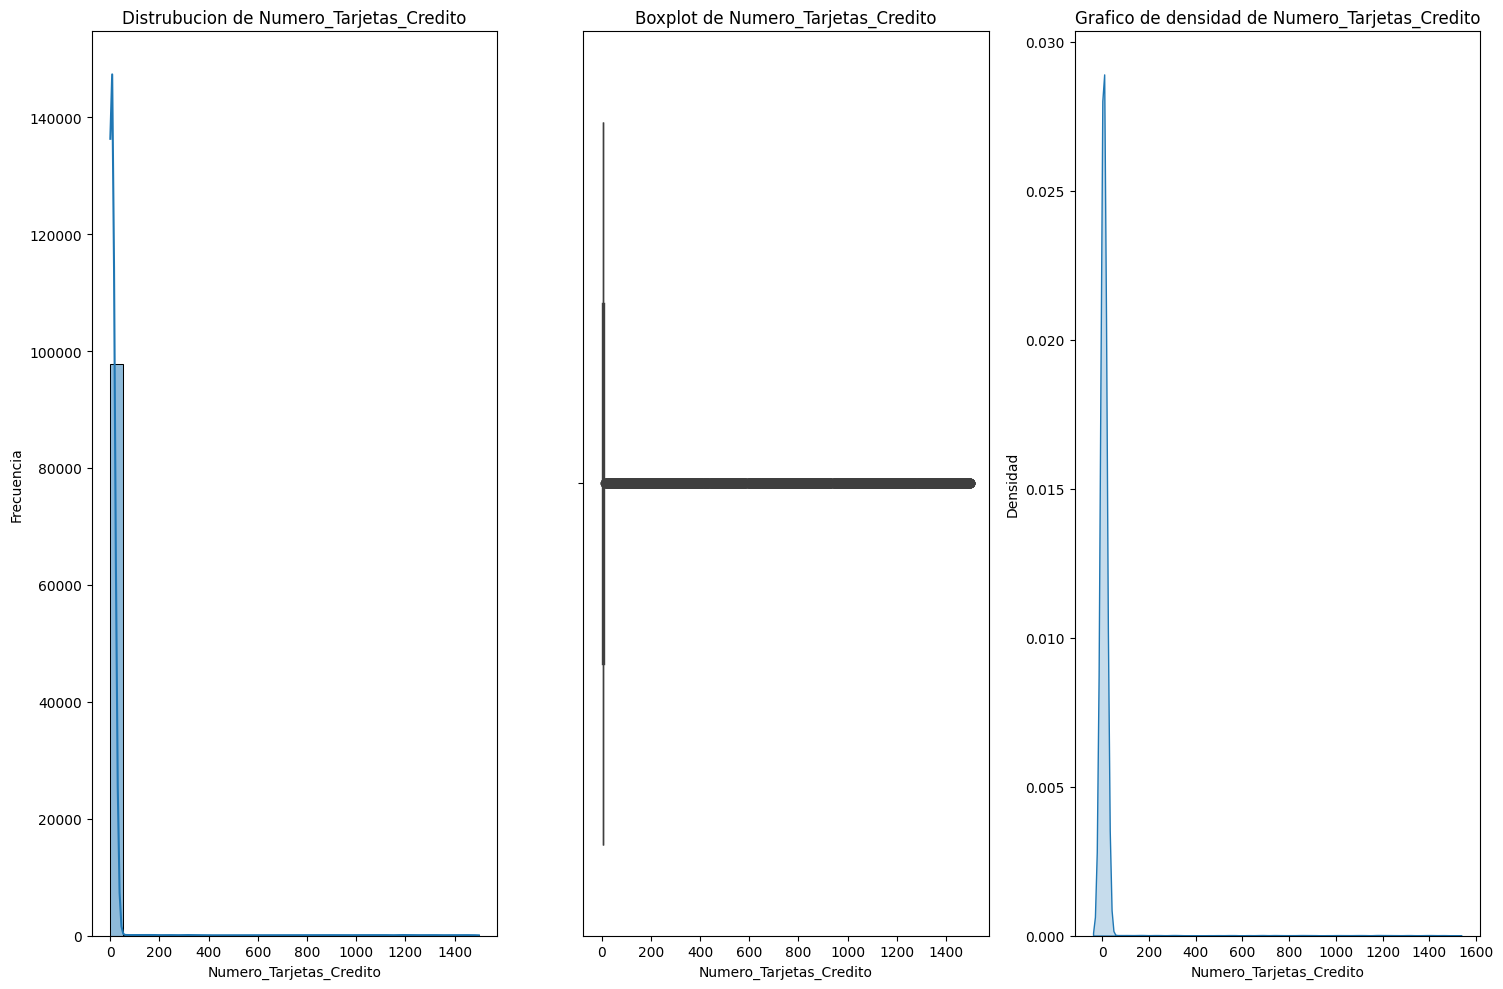

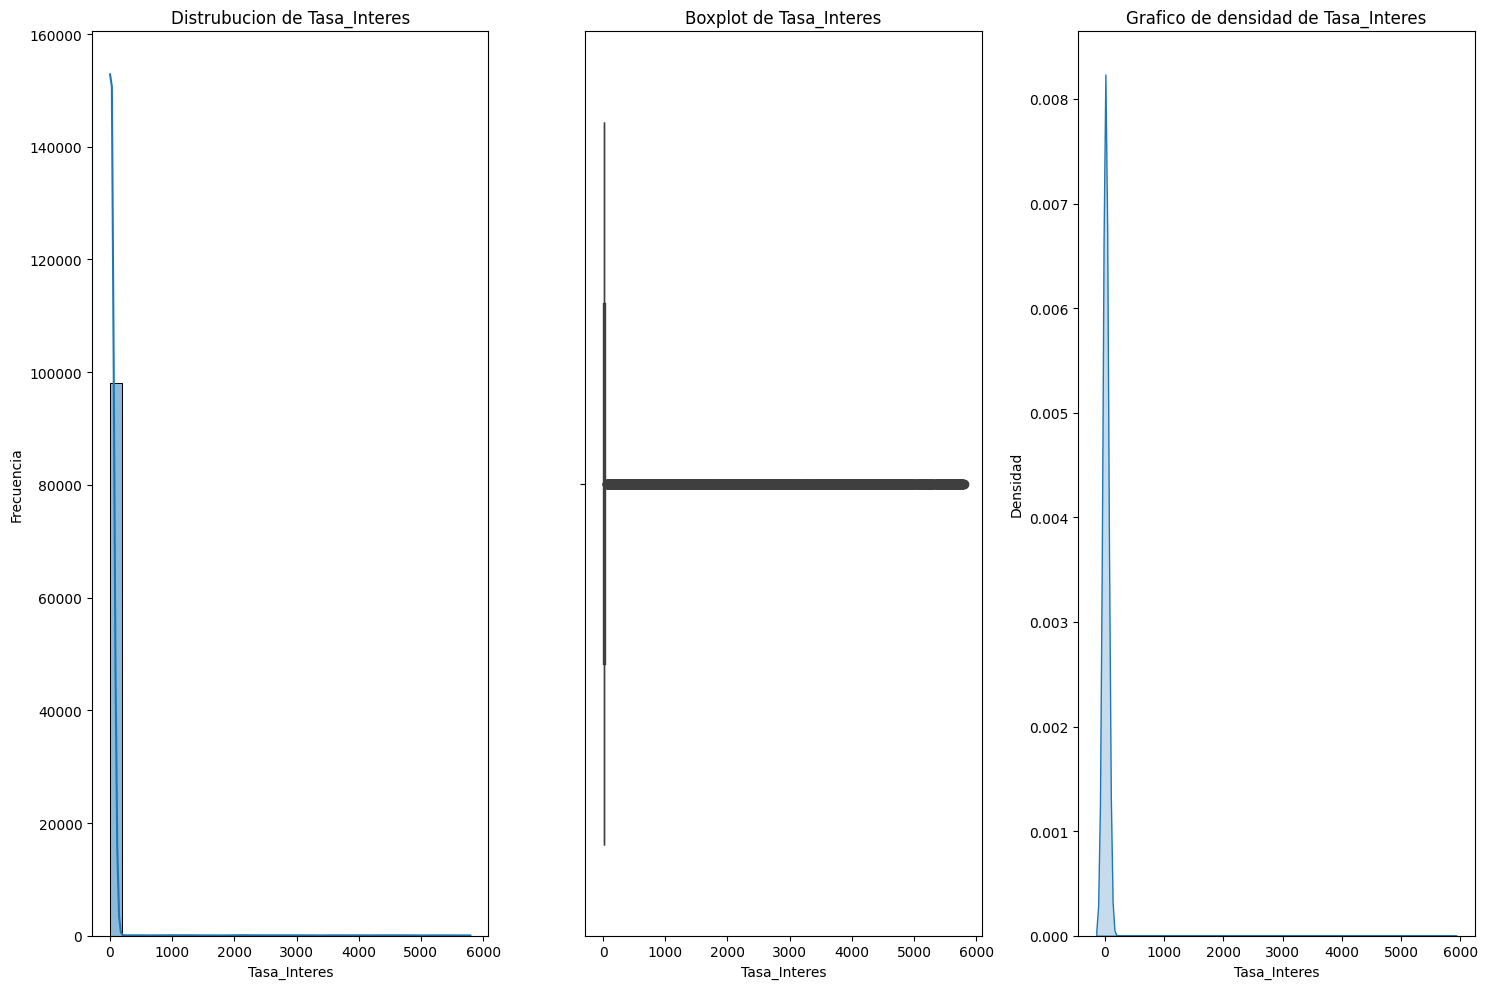

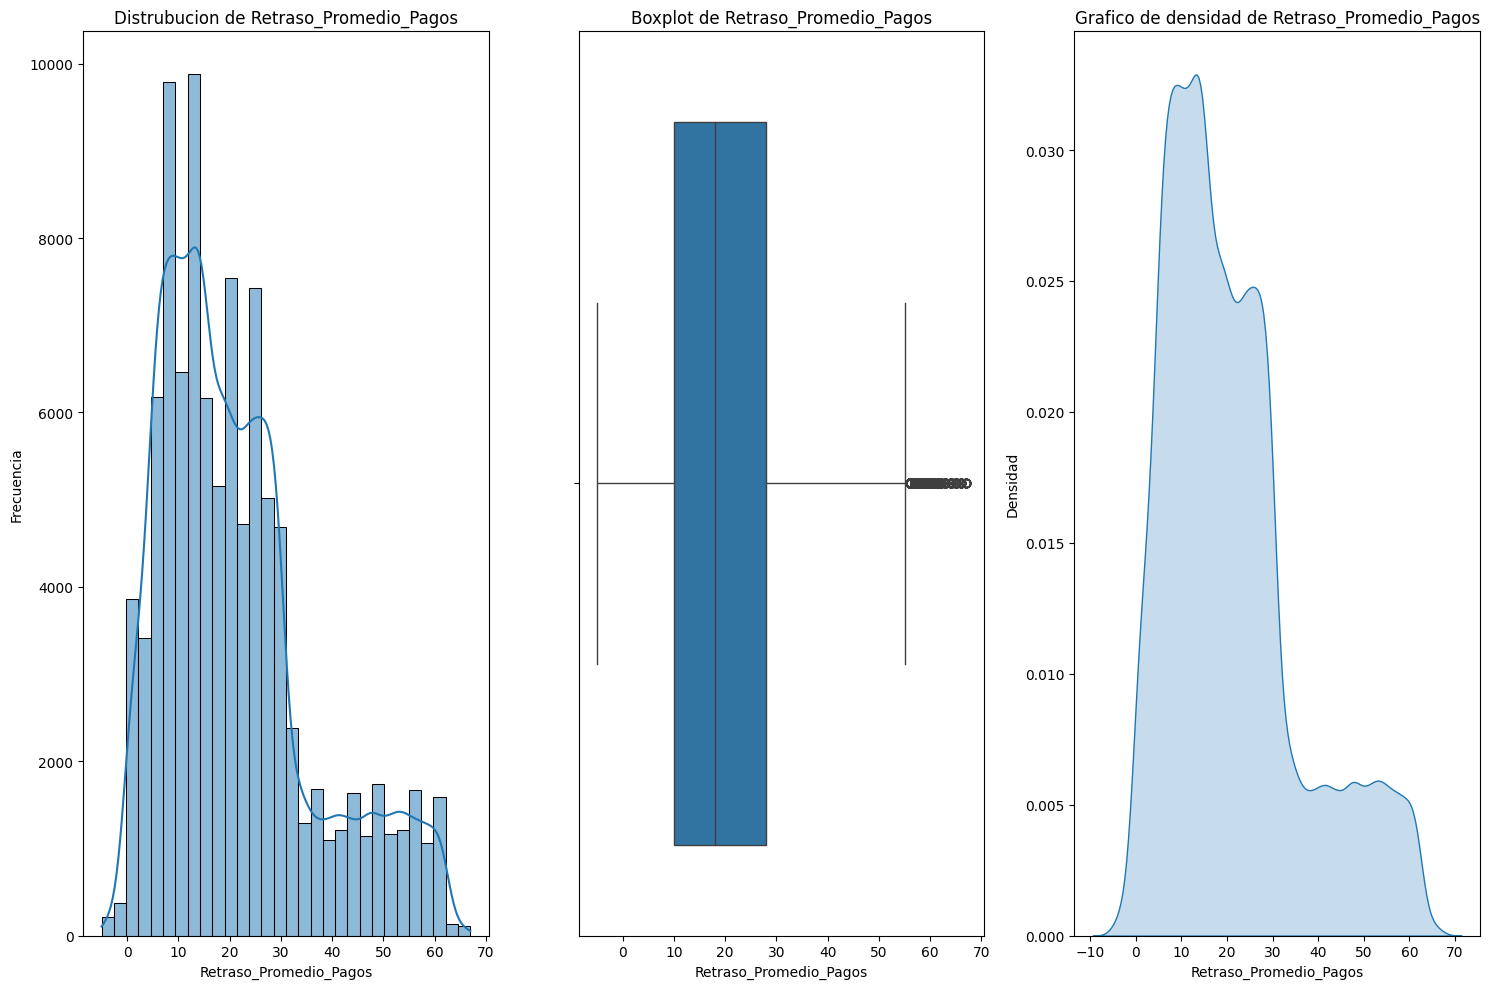

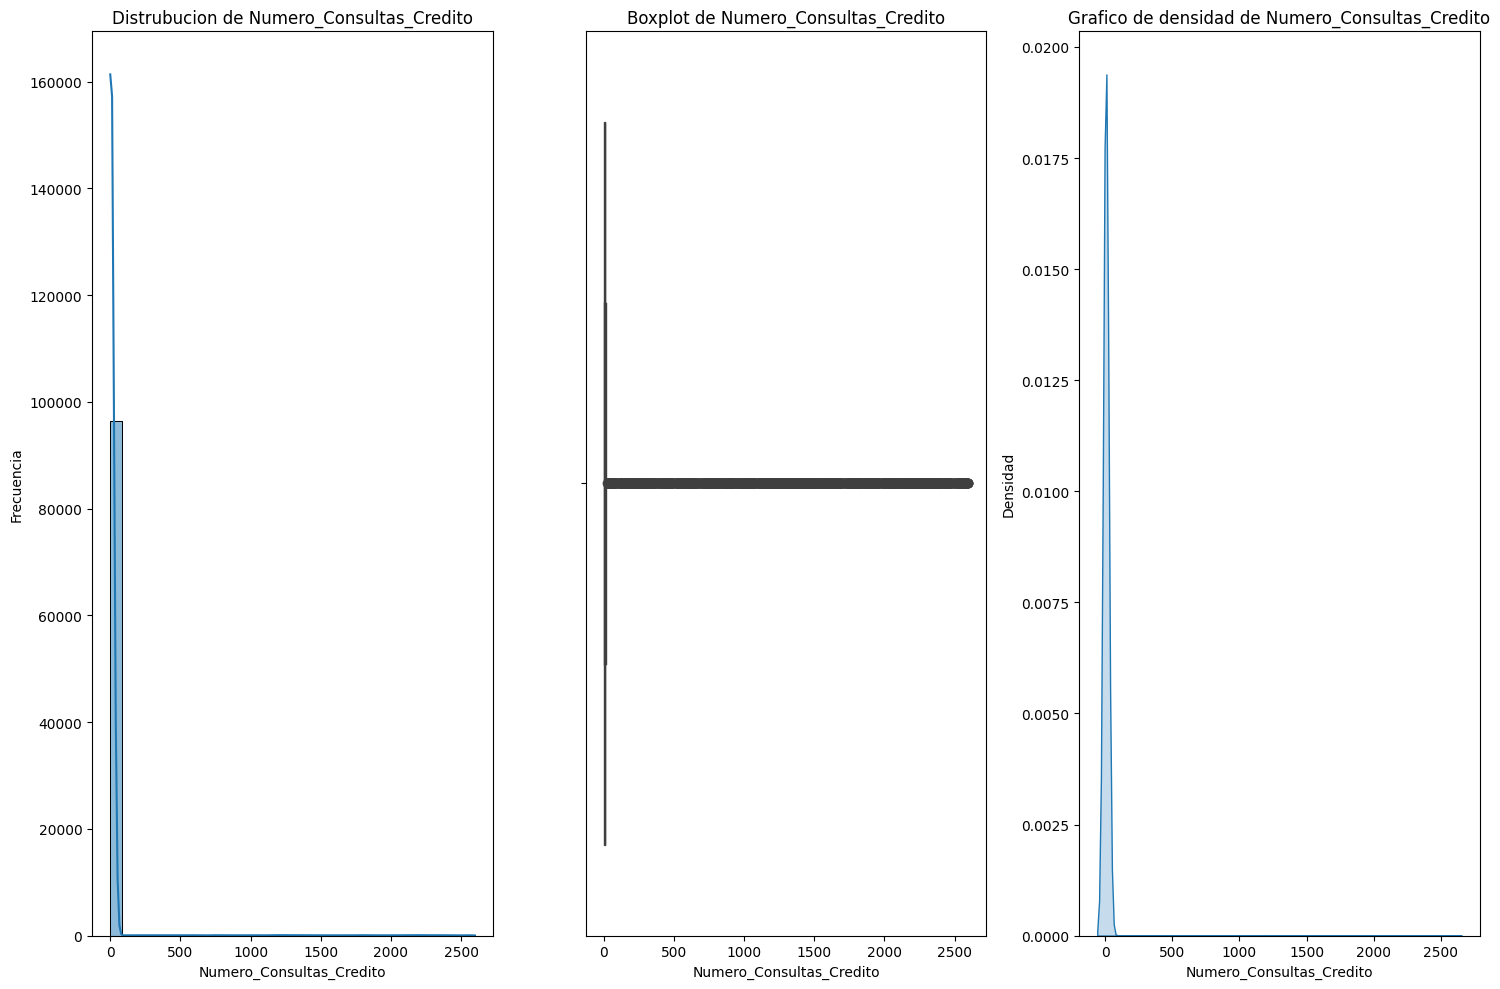

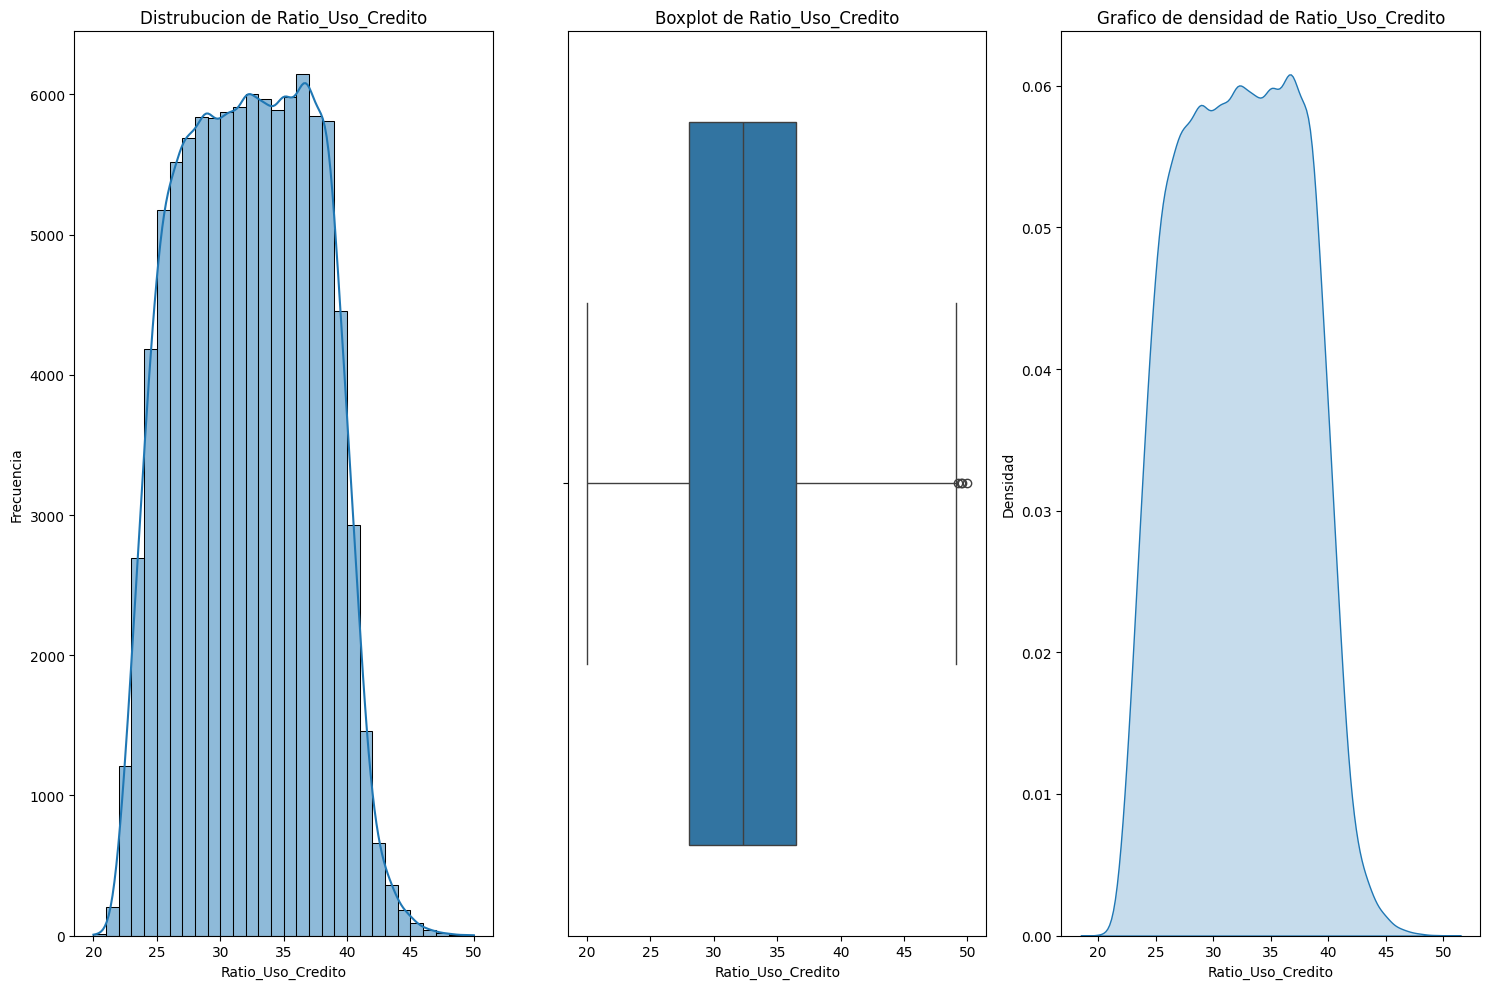

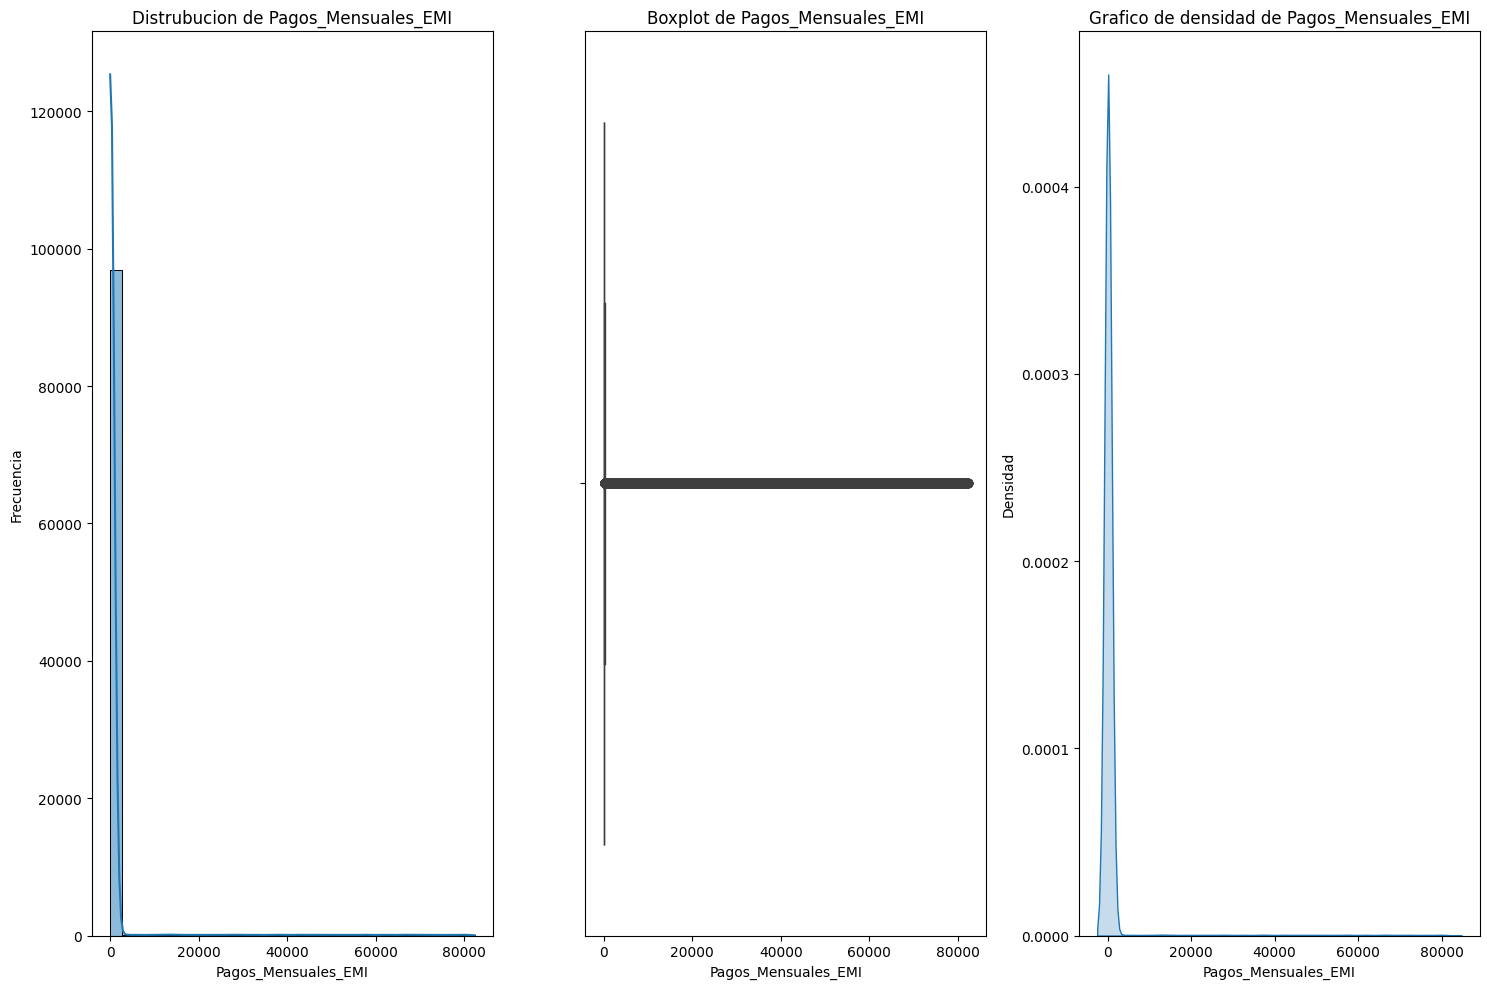

In [38]:
###Haremos una funcion para anlizar la distribucion de nuestras variables numericas.
def analisis_numerico(df):
    columna_numerica= df.select_dtypes(include=['number'])
    for columna in columna_numerica:
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        sns.histplot(df[columna].dropna(), kde=True, bins=30)
        plt.title(f'Distrubucion de {columna}')
        plt.xlabel(columna)
        plt.ylabel('Frecuencia')
        
        plt.subplot(1,3,2)
        sns.boxplot(x=df[columna].dropna())
        plt.title(f'Boxplot de {columna}')
        plt.xlabel(columna)
        
        plt.subplot(1,3,3)
        sns.kdeplot(df[columna].dropna(), fill=True)
        plt.title(f'Grafico de densidad de {columna}')
        plt.xlabel(columna)
        plt.ylabel('Densidad')
        
        plt.tight_layout()
        plt.show()
        
analisis_numerico(data_2)
        
        

Continuamos con el analisis descriptivo de las variables categoricas, con este se pretende entender la frecuencia absoluta y relativa de cada una y determinar de forma inicial como podrian tomar partido en el desempenio de nuestro modelo

In [40]:
#Primero vemos una lista de las variables categoricas 

varibles_categoricas = ['Ocupacion', 'Ingreso_Anual',
                        'Numero_Prestamos', 
                        'Tipo_Prestamos', 
                    'Cambio_Limite_Credito', 
                    'Mezcla_Credito',
                    'Deuda_Pendiente', 
                    'Antiguedad_Historial_Credito',
                    'Pago_Monto_Minimo', 
                    'Monto_Mensual_Invertido',
                    'Comportamiento_Pago', 
                    'Puntaje_Credito']

Haremos una funcion para ver frecuencia absoluta y relativa de cada variable 

In [68]:
import pandas as pd

def frecuencia_categoricas(df):
    for columna in df.select_dtypes(include='object').columns:
        print(f"Frecuencia absoluta de {columna}:\n{df[columna].value_counts()}\n")
        print(f"Frecuencia relativa de {columna}:\n{df[columna].value_counts(normalize=True)}\n")

frecuencia_categoricas(data_2)


Frecuencia absoluta de Edad:
Edad
38      2833
28      2829
31      2806
26      2792
32      2749
        ... 
471        1
1520       1
8663       1
3363       1
1342       1
Name: count, Length: 1788, dtype: int64

Frecuencia relativa de Edad:
Edad
38      0.02833
28      0.02829
31      0.02806
26      0.02792
32      0.02749
         ...   
471     0.00001
1520    0.00001
8663    0.00001
3363    0.00001
1342    0.00001
Name: proportion, Length: 1788, dtype: float64

Frecuencia absoluta de Ocupacion:
Ocupacion
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

Frecuencia relativa de Ocupacion:
Ocupacion
_______          0.07062
Lawyer           0.06575
Archite

### Notas Guardadas (Invertidas y Numeradas):

1. **C:1** NM en Pago_Monto_Minimo probablemente significa "No Mencionado" o "No Disponible"
2. **C:2** edad tiene valores atípico de conteo igual a uno y sin sentido
3. **C:3** numero de prestamos presenta el mismo problema que edad
4. **C:4** tipo de prestamos tiene muchas categorías, podemos reducirlo haciendo clasificación con un modelo de aprendizaje no supervisado
5. **C:5** se puede hacer lo mismo con ingreso anual para dejarla categórica y que tenga menos categorías
6. **C:6** numero promedio de pagos retrasados puede tener el mismo problema que edad, pero en este caso considero que si puede volverse numerica y podemos eliminar los outliers o reemplazarlos con ceros
7. **C:7** cambio limite de credito es una variable numerica por completo, no hay nada que discutir unicamente debemos convertirla a numerica
8. **C:8** en mezcla _credito cambiar la categoría de -- por un NO
9. **C:9** deuda pendiente es una variable numerica
10. **C:10** antiguedad de historial de credito puede convertirse en numerica utilizando solo un tipo de tensor
11. **C:11** pago_monto_minimo, actualizar nombre a solo pago monto minimo, también, tenemos NM que es no mencionado, recomiendo dejarla así
12. **C:12** monto mensual invertido, es una variable numerica no categorica
13. **C:13** comportamiento de pago tiene un valor de categoría que no tiene sentido, el cual debemos cambiar a desconocido
14. **C:14** balance mensual es una variable numerica



In [62]:
def analisis_frecuencia_categorica(df, var_cat):
    frecuencias = []
    for var in var_cat:
        absoluta = df[var].value_counts()
        relativa = df[var].value_counts(normalize=True)
        
        df_frecuencias = pd.DataFrame({
            'Frecuencia Absoluta': absoluta,
            'Frecuencia Relativa': relativa
        })
        
        df_frecuencias['Variable'] = var
        categoria = 'Categoria'
        df_frecuencias = df_frecuencias.reset_index().rename(columns={'index': categoria})
        
        print(df_frecuencias.columns)
        print(df_frecuencias.head())
        
        
        try:
            df_frecuencias = df_frecuencias[['Variable', categoria, 'Frecuencia Absoluta', 'Frecuencia Relativa']]
        except KeyError as e:
            print(f"Error al reordenar las columnas: {e}")
            print(df_frecuencias.columns)
            raise e
        
        frecuencias.append(df_frecuencias)
    
    return pd.concat(frecuencias, ignore_index=True)


In [63]:
analisis_frecuencia_categorica(data_2, varibles_categoricas)

Index(['Ocupacion', 'Frecuencia Absoluta', 'Frecuencia Relativa', 'Variable'], dtype='object')
   Ocupacion  Frecuencia Absoluta  Frecuencia Relativa   Variable
0    _______                 7062              0.07062  Ocupacion
1     Lawyer                 6575              0.06575  Ocupacion
2  Architect                 6355              0.06355  Ocupacion
3   Engineer                 6350              0.06350  Ocupacion
4  Scientist                 6299              0.06299  Ocupacion
Error al reordenar las columnas: "['Categoria'] not in index"
Index(['Ocupacion', 'Frecuencia Absoluta', 'Frecuencia Relativa', 'Variable'], dtype='object')


KeyError: "['Categoria'] not in index"

In [64]:
def ver_nulos(df):
    nulos = df.isnull().sum()
    caracteristicas_con_nulos = nulos[nulos>0]
    return pd.DataFrame({
        'columna': caracteristicas_con_nulos.index,
        'valores nulos': caracteristicas_con_nulos.values
    })
    

In [65]:
ver_nulos(data_2)

,columna,valores nulos
0,Salario_Mensual_En_Mano,15002
1,Tipo_Prestamos,11408
2,Numero_Promedio_Pagos_Retrasados,7002
3,Numero_Consultas_Credito,1965
4,Antiguedad_Historial_Credito,9030
5,Monto_Mensual_Invertido,4479
6,Balance_Mensual,1200


In [67]:
data_2.head(3)

,Edad,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Numero_Prestamos,Tipo_Prestamos,Retraso_Promedio_Pagos,...,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual,Puntaje_Credito
0,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,...,Good,809.98,31.944960,None,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
